# Aloha Ship and Pack - Mililani

## Setup

### File Paths

In [6]:
TRANSACTIONS_2019 = 'data/records_2019_trimmed.csv'
TRANSACTIONS_2020 = 'data/records_2020_trimmed.csv'
TRANSACTIONS_2021 = 'data/records_2021_trimmed.csv'
YEARS_COVERED = '2019 to 2021'
DEPARTMENTS  = 'data/sku_to_departments.csv'
RETAIL_CATS  = 'data/retail_categories.csv'

### Packages

In [359]:
from geopy.geocoders import Bing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prefixspan import PrefixSpan
import seaborn as sns
import sklearn
import os
from datetime import datetime
import pyfpgrowth

## Load/Prep Data

### Load CSVs into Dataframes

In [8]:
def load_csvs():
    transactions = pd.read_csv(TRANSACTIONS_2019)
    for each in [TRANSACTIONS_2020, TRANSACTIONS_2021]:
        t_df = pd.read_csv(each)
        transactions = transactions.append(t_df)

    transactions.reset_index(drop=True, inplace=True)
    sku2department = pd.read_csv(DEPARTMENTS)
    
    del(t_df)
    return transactions, sku2department


### Clean transactions dataframe

In [9]:
def clean_dataframe(trans_df):
    #column names
    cols_dict = {
        'Payment Method' : 'Payment_Method',
        'Department' : 'Item_Name',
        'Unit Price' : 'Unit_Price',
        'Disc' : 'Discount',
        'Ext Price' : 'Extended_Price',
        'Sub-Total:' : 'Sub_Total',
        'Sales Tax:' : 'Sales_Tax',
        'Invoice Total:' : 'Invoice_Total',
    }
    trans_df.rename(columns=cols_dict, inplace=True)

    #remove $ signs and commas
    cols_to_strip = ['Unit_Price', 'Extended_Price', 'Sub_Total', 'Invoice_Total']
    for col in cols_to_strip:
        trans_df[col] = trans_df[col].apply(lambda x: x.replace('$', ''))
        trans_df[col] = trans_df[col].apply(lambda x: x.replace(',', ''))

    #make (###) into -###
    trans_df.reset_index(drop=True, inplace=True)
    cols_to_sign = ['Unit_Price', 'Extended_Price', 'Sub_Total', 'Invoice_Total']
    for col in cols_to_sign:
        idxs_to_change = trans_df[col].str.contains("(", regex=False).to_numpy().nonzero()[0]
        for i in idxs_to_change:
            cell = "-" + trans_df.at[i,col][1:-1]
            trans_df.at[i,col] = cell

    #change types to float
    cols_to_float = ['Unit_Price', 'Extended_Price', 'Sub_Total', 'Sales_Tax', 'Invoice_Total']
    for col in cols_to_float:
        trans_df[col] = trans_df[col].astype(float)

    #combine date and time into a datetime object instead of just strings
    trans_df['DateTimeStamp'] = pd.to_datetime(trans_df.Date + " " + trans_df.Time)
    trans_df['DateStamp'] = pd.to_datetime(trans_df.Date)

    #drop original columns so its not confusing
    trans_df.drop(['Date', 'Time'], axis=1, inplace=True)
    
    return trans_df
    

In [489]:
def clean_dept_records(trans_df):
    #change Misc Non Tax into misc-non-tax so it doesnt mess with pattern finding
    trans_df.loc[(trans_df.Department == 'MISC NON TAX'), 'Department'] = 'Rewards'

    #Address missing SKU2Department Records that leave an NA in Department
    missing_idxs = trans_df.Department.isna().to_numpy().nonzero()[0]

    for i in missing_idxs:
        cell = trans_df.at[i, 'SKU']
        if 'FEDEX' in cell or 'OAHU-GND' in cell:
            trans_df.at[i, 'Department'] = 'FEDEX'
        elif 'USPS' in cell or 'FIRSTCLASS' in cell or 'FirstClass' in cell:
            trans_df.at[i, 'Department'] = 'USPS'
        elif 'DHL' in cell:
            trans_df.at[i, 'Department'] = 'DHL'
        elif 'MBDWCLUTCH' in cell or 'MBDVOTIVE' in cell:
            trans_df.at[i, 'Department'] = 'RETAIL' 
        elif 'WWXSVR' in cell:
            trans_df.at[i, 'Department'] = 'UPS'

    # Single letter items
    fl = ['F3.5', 'F5', 'F3', 'F2', 'F4', 'F1', 'F10', 
            'F6', 'F9', 'F7', 'F8', 'F11', 'F12', 'F13']
    ml = ['M2','M3']
    pl = ['P4', 'P3', 'P5', 'P12', 'P3.5','P1', 'P2', 
            'P6', 'P7', 'P9', 'P8', 'P10', 'P11']

    trans_df.loc[(trans_df.SKU.isin(fl)), 'Department'] = 'USPS'
    trans_df.loc[(trans_df.SKU.isin(ml)), 'Department'] = 'USPS'
    trans_df.loc[(trans_df.SKU.isin(pl)), 'Department'] = 'USPS'
    trans_df.loc[(trans_df.SKU.isin(['MBXR', 'MBX'])), 'Department'] = 'MAILBOX'
        
    post_missing_idxs = trans_df.Department.isna().to_numpy().nonzero()[0]
    print("# of Missing department records to get dropped: ", len(post_missing_idxs))

    #drop remaining NAs
    trans_df.dropna(inplace=True)

    return trans_df

In [488]:
#clean/process data into a dataframe
if 'transactions' in locals() or 'transactions' in globals():
    print('deleting transactions dataframe')
    del transactions

retail_cats = pd.read_csv(RETAIL_CATS)
transactions, sku2department = load_csvs()
transactions = clean_dataframe(transactions)
transactions = pd.merge(transactions, sku2department[['SKU', 'Department']], 
                how='left', left_on='SKU', right_on='SKU')
transactions = clean_dept_records(transactions)
transactions = pd.merge(transactions, retail_cats, 
                how='left', left_on='Item_Name', right_on='Item')
transactions.rename(columns={'Item_type':'Retail_category'}, inplace=True)

print('transactions shape: ', transactions.shape)

deleting transactions dataframe
Removing $ signs and commas
converting negative numbers to numerical type string
changing numberical types to float
# of Missing department records to get dropped:  25
transactions shape:  (71932, 16)


## Save/Load Dataframes

In [531]:
#save dataframe for easier loading
today = datetime.today().date()

TRANSACTIONS_DF_FILE_PATH = f"dataframes/transactions_dataframe_{today}.csv"
transactions.to_csv(TRANSACTIONS_DF_FILE_PATH, index=False)
print(TRANSACTIONS_DF_FILE_PATH)

FIRST_TRANS_FILE_PATH = f"dataframes/First_Trans_df_{today}.csv"
first_transactions.to_csv(FIRST_TRANS_FILE_PATH, index=False)
print(FIRST_TRANS_FILE_PATH)

ADDRESS_LIST_FILE_PATH = f"dataframes/Customer_Locations_{today}.csv"
customer_location_df.to_csv(ADDRESS_LIST_FILE_PATH, index=False)
print(ADDRESS_LIST_FILE_PATH)

dataframes/transactions_dataframe_2022-03-15.csv
dataframes/First_Trans_df_2022-03-15.csv
dataframes/Customer_Locations_2022-03-15.csv


In [499]:
###load PROCESSED dataframe from csv
### Remove if existing

for df in ['transactions', 'first_transactions', 'customer_location_df']:
    if df in locals() or df in globals():
        print(f'deleting {df} dataframe')
        del df

date = "2022-03-15"
transactions = pd.read_csv(f'dataframes/transactions_dataframe_{date}.csv')
first_transactions = pd.read_csv(f'dataframes/First_Trans_df_{date}.csv')
customer_location_df = pd.read_csv(f"dataframes/Customer_Locations_{date}.csv")

print('Transactions shape:          ', transactions.shape)
print('First Transactions shape:   ', first_transactions.shape)
print('Customer Locations shape: ', customer_location_df.shape)

deleting transactions dataframe
deleting first_transactions dataframe
deleting customer_location_df dataframe
Transactions shape:           (71932, 16)
First Transactions shape:    (5558, 5)
Customer Locations shape:  (5605, 4)


## Helper Methods (Other)

In [ ]:
#write unique items to a csv for further categorization
header = "Item, Item_type"
with open('items.csv', 'w') as f:
    f.writelines(header)
    for item in transactions[transactions.Department == 'RETAIL'].Item_Name.unique():
        line = item + ", \n"
        f.write(line)

In [105]:
#for prefixspan CLI
def write_first_transactions_to_file(first_trans, file_name='output.txt'):
    with open(file_name, 'w') as f:
        for line in first_trans:
            output_line = ""
            for element in line:
                output_line = output_line + element + ' '
            output_line = output_line[:-1] + '\n'
            f.writelines(output_line)

## Transactions by Volume and total sales amount

In [49]:
info = pd.DataFrame(transactions.Department.value_counts())
info.reset_index(inplace=True)
info.columns = ['Department', 'Counts']

#Departments by sales volume
sales_volume = []
for dept in transactions.Department.unique():
    t_s = transactions[transactions.Department == dept]['Extended_Price']
    t_s = int(sum(t_s))
    sales_volume.append( (dept,t_s) )

sv_df = pd.DataFrame(sales_volume)
sv_df.columns = ['Department', 'Total_Sales']

counts_total_sales_df = pd.merge(info, sv_df, how='outer', left_on='Department', right_on='Department')

#created 'normed' sales volume so it doesnt throw off the graph
sales_max = counts_total_sales_df.Total_Sales.max()
counts_max = counts_total_sales_df.Counts.max()

counts_total_sales_df['normed_total_sales'] = counts_total_sales_df.Total_Sales / sales_max
counts_total_sales_df['normed_total_sales'] = (counts_total_sales_df['normed_total_sales'] * counts_max).astype(int)

#drop MISC NON TAX as its not really a sales item and its vague
idx = counts_total_sales_df[counts_total_sales_df.Department == 'MISC NON TAX'].index
counts_total_sales_df.drop(idx, inplace=True)

#remove negatives as its throwing off the graph and not very informational
counts_total_sales_df.loc[(counts_total_sales_df.normed_total_sales < 0), 'normed_total_sales'] = 0


In [12]:
counts_total_sales_df

,Department,Counts,Total_Sales,normed_total_sales
0,USPS,21317,413180,21317
1,COPIES,13155,87635,4521
2,RETAIL,11783,119245,6152
3,NOTARY,6799,101348,5228
4,FAX,4276,23108,1192
5,METER,4228,13914,717
7,FEDEX,2262,255359,13174
8,CARDS,1049,8533,440
9,PACK,747,11609,598
10,UPS,706,114870,5926


Text(0.5, 1.0, 'By Number of Transactions')

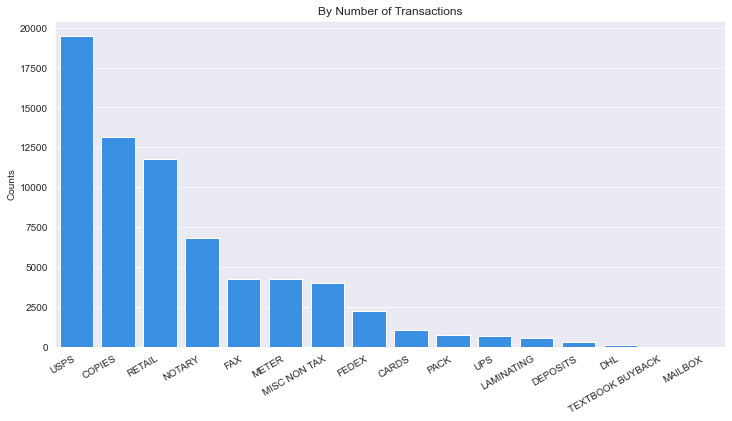

In [132]:
#Departments by number of transactions 
sns.set_style('darkgrid')
plt.figure(figsize = (12,6))
ax = sns.barplot(data = counts_total_sales_df, x='Department', y='Counts', color='dodgerblue')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, ha = 'right')
ax.set_xlabel('')
plt.title("By Number of Transactions")


Text(0.5, 1.0, 'By Sales Volume')

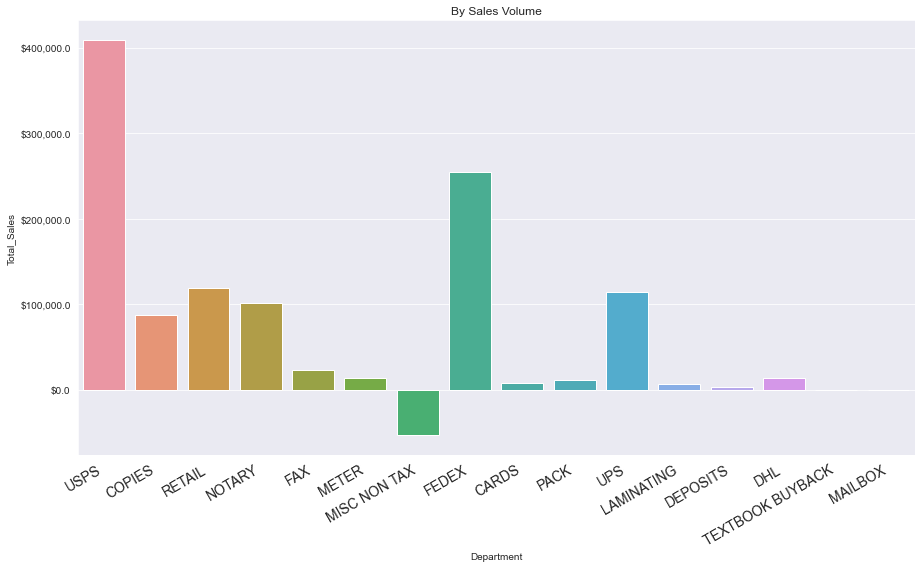

In [134]:
sns.set_style('darkgrid')
plt.figure(figsize = (15,8))
ax = sns.barplot(data = counts_total_sales_df, x='Department', y='Total_Sales')
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation = 30, ha = 'right', size = 14)
ax.yaxis.set_major_formatter('${x:,}')
# ax.set_yticklabels(ax.get_yticklabels(), size = 14)
plt.title("By Sales Volume")

### Combined Graph

/var/folders/yz/6drrhg0x63596m99cvrlz3xc0000gp/T/ipykernel_3377/3486230730.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax2.set_yticklabels(["$0", "$115,000", "$230,000", "$345,000", "$465,000"])


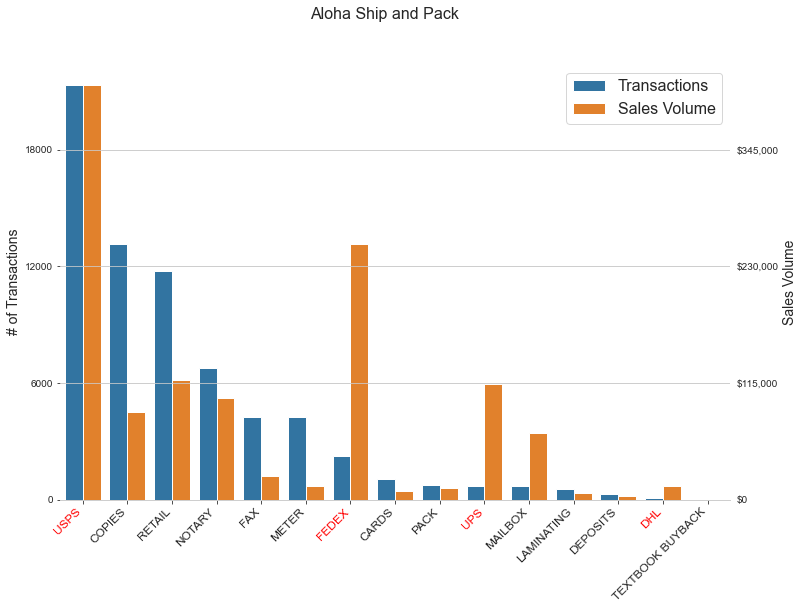

In [51]:
BASE_FONT_SIZE = 14
TITLE_FONT_SIZE = 16
info_df = counts_total_sales_df[['Department', 'Counts', 'normed_total_sales']]
info_melt = pd.melt(info_df, id_vars="Department")

sns.set_style('whitegrid')
fig, ax1 = plt.subplots()
fig.set_size_inches(12,8)

b = sns.barplot(x='Department', y='value', hue='variable', data=info_melt)

###adjust the look of the plot
## x-axis
x_tick_labels = ax1.xaxis.get_ticklabels()
_ = ax1.xaxis.set_ticklabels(x_tick_labels, rotation = 45, ha = 'right', size = BASE_FONT_SIZE-2)
_ = ax1.xaxis.set_label_text("")


#colorize the x labels
shipping_companies = ['USPS', 'UPS', 'FEDEX', 'DHL']
for tick in x_tick_labels:
    tick_text = tick.get_text()
    if tick_text in shipping_companies : tick.set_color('red')

## y-axis
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))
_ = ax1.yaxis.set_label_text("# of Transactions")
ax1.yaxis.label.set_fontsize(BASE_FONT_SIZE)

#right side y-axis
ax2 = ax1.twinx()
ax2.set_ylim(ax1.get_ylim())
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
_ = ax2.set_yticklabels(["$0", "$115,000", "$230,000", "$345,000", "$465,000"])
ax2.set_ylabel('Sales Volume', fontsize=BASE_FONT_SIZE)

#adjust the legend
ax1.legend(fontsize = TITLE_FONT_SIZE)

# legend.set_title('')
for t, l in zip(ax1.legend_.texts, ('Transactions', "Sales Volume")):
    t.set_text(l)

# other
ax1.tick_params(bottom=True)
ax2.tick_params(left=False, right=False)
sns.despine(left=True, bottom=False, right=True)
fig.suptitle("Aloha Ship and Pack", fontsize=TITLE_FONT_SIZE)

plt.savefig('figures/trans_by_sales-volume.jpg', bbox_inches='tight')
plt.show()

### Historgram of shipping companies

In [9]:
#data
usps_trans  = transactions[(transactions.Department == 'USPS') & (transactions.Extended_Price > 0)]['Extended_Price']
fedex_trans = transactions[(transactions.Department == 'FEDEX') & (transactions.Extended_Price > 0)]['Extended_Price']
dhl_trans   = transactions[(transactions.Department == 'DHL') & (transactions.Extended_Price > 0)]['Extended_Price']

usps_avg  = np.average(usps_trans)
fedex_avg = np.average(fedex_trans)
dhl_avg   = np.average(dhl_trans)

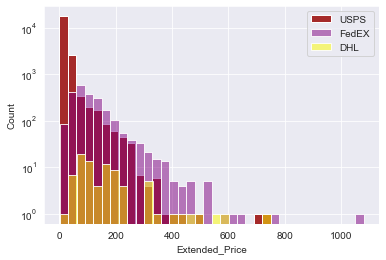

In [174]:
EDGE_C = '1'
LINE_W = '1'
BIN_WDTH = 30


b = sns.histplot()
sns.histplot(data = usps_trans, color='brown', alpha=1, bins=20, label='USPS', binwidth=BIN_WDTH)
sns.histplot(data = fedex_trans, color='purple', bins=20, label='FedEX', alpha = 0.5, binwidth=BIN_WDTH)
sns.histplot(data = dhl_trans, color='yellow', bins=10, label='DHL', alpha = 0.5, binwidth=BIN_WDTH)
b.set_yscale('log')

plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

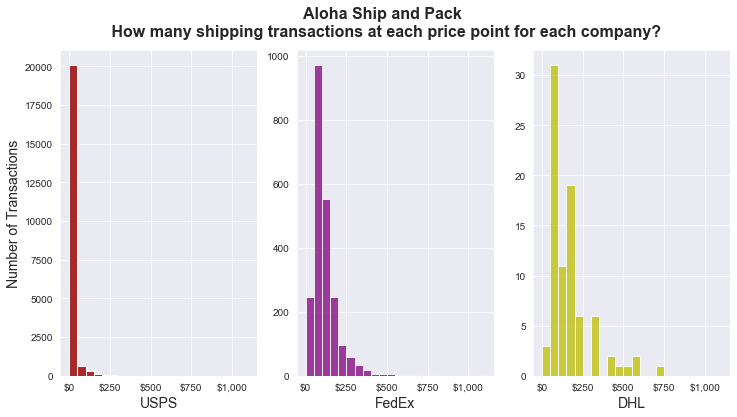

In [47]:
EDGE_C = '1'
LINE_W = '1'
BASE_FONT_SIZE = 14
BIN_WDTH = 50

plt.figure()
fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharey=False, sharex=True)
ax1, ax2, ax3 = axes

#plots
sns.histplot(ax=ax1, 
            data = usps_trans, label='USPS',
            color='brown', alpha=1, bins=20,  binwidth=BIN_WDTH)
sns.histplot(ax=ax2, 
            data = fedex_trans, label='FedEX',
            color='purple', bins=20, binwidth=BIN_WDTH)
sns.histplot(ax=ax3, data = dhl_trans, 
            color='y', bins=10, label='DHL', binwidth=BIN_WDTH)

#xaxis
ax1.xaxis.set_label_text('USPS', fontsize=BASE_FONT_SIZE)
ax2.xaxis.set_label_text('FedEx', fontsize=BASE_FONT_SIZE)
ax3.xaxis.set_label_text('DHL', fontsize=BASE_FONT_SIZE)

ax1.xaxis.set_major_formatter('${x:,.0f}')

#yaxis
ax1.yaxis.set_label_text("Number of Transactions", fontsize=BASE_FONT_SIZE)
ax2.yaxis.set_label_text("")
ax3.yaxis.set_label_text("")

#other
sns.set_style('darkgrid')
fig.suptitle('Aloha Ship and Pack \n How many shipping transactions at each price point for each company?', fontsize=16, fontweight='bold')
# plt.title("thing")

plt.savefig("figures/shipping_trans.jpg")
plt.show()


## What do customers buy during their first named transaction?

In [490]:
###load and prep data
customers = list(transactions.Customer.unique())
customers.pop(customers.index('Cash, Check, Charge'))

first_transactions = transactions.sort_values(by=['Customer','DateStamp']).groupby('Customer').head(1)
first_transactions = first_transactions[['Customer', 'DateStamp']]
first_transactions['transactions'] = None
first_transactions['retail_cat'] = None
first_transactions.reset_index(drop=True, inplace=True)

customers = list(transactions.Customer.unique())
print("Total Customers = ", len(customers))
for i, customer in enumerate(customers):
    if i % 250 == 0 : print(str(i) + "  ", end="")
    cust_first_date = first_transactions[first_transactions.Customer == customer]['DateStamp']
    cust_first_date = cust_first_date.item()

    tdf = transactions.loc[(transactions.Customer == customer) & (transactions.DateStamp == cust_first_date)]
    cust_trans = list(tdf['Department'].unique()) #get rid of duplicates [USPS, USPS] but keep as a list
    cust_trans = sorted(cust_trans)
    cust_idx = first_transactions[first_transactions.Customer == customer].index[0]
    first_transactions.at[cust_idx, 'transactions'] = cust_trans

    cust_retail = tdf.Retail_category.unique()
    first_transactions.at[cust_idx, 'retail_cat'] = cust_retail

    # if i > 0 : print(cust_retail)
    # if i > 3 : break
first_transactions['original_trans'] = first_transactions.transactions
first_transactions.transactions = first_transactions.transactions.apply(lambda x: '/'.join(x))

Total Customers =  5558
0  250  500  750  1000  1250  1500  1750  2000  2250  2500  2750  3000  3250  3500  3750  4000  4250  4500  4750  5000  5250  5500  

#### Prefix Span

In [92]:
#Prefix Span
ps = PrefixSpan(first_transactions.transactions)
topk = ps.topk(15, closed=False)

#doesnt work as desired. Is sequential.  Want frequent patterns as 'sequential' in a single purchase is non-sensical.

#### FP Growth

In [123]:
trans = first_transactions.transactions
patterns = pyfpgrowth.find_frequent_patterns(trans, support_threshold=100)

#get the top 15 patterns
patterns = sorted(patterns.items(), key=lambda x: x[1], reverse=True)[:15]

## make results graphable
num_hits, pattern = [], []
for each in patterns:
    num_hits.append(each[1])
    t = '/'.join(each[0])
    pattern.append(t)

#### Value counts

In [310]:
patterns = first_transactions.transactions.value_counts()[0:15]

## make results graphable
num_hits, pattern = [], []
for each in patterns.items():
    num_hits.append(each[1])
    pattern.append(each[0])

#### Top 15 first Transactions Visualization

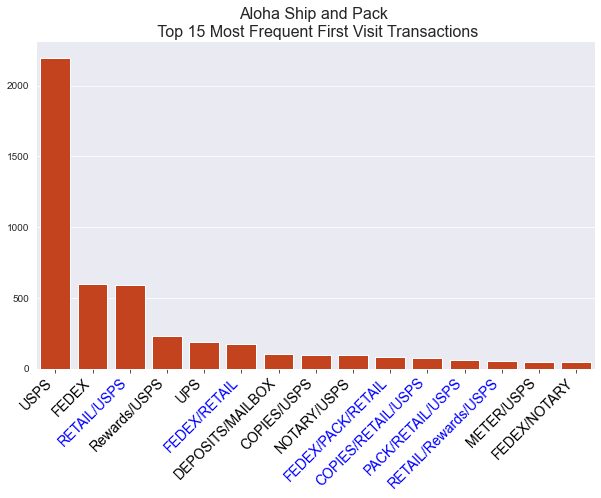

In [312]:
#### Visualizations
BASE_FONT_SIZE = 14
TITLE_FONT_SIZE = 16
sns.set_style('darkgrid')
retail = [2,5,9,10,11,12]
# rewards = [3,12]

colors = []
for i in range(len(pattern)):
    # if i in rewards:
    #     colors.append('green')
    if i in retail:
        colors.append('blue')
    else:
        colors.append('black')

#create plot
fig = plt.figure()
fig.set_size_inches(10,6)
b = sns.barplot(x=pattern, y=num_hits, color='#DD3403')

#xaxis
_ = b.xaxis.set_ticklabels(b.xaxis.get_ticklabels(), rotation = 45, ha = 'right', size = BASE_FONT_SIZE)
for i, tick_label in enumerate(b.axes.get_xticklabels()):
    tick_label.set_color(colors[i])

#yaxis
# b.yaxis.set_ticklabels(b.yaxis.get_ticklabels(), size=BASE_FONT_SIZE)
# b.yaxis.label.set_fontsize(20)

#other
b.tick_params(bottom=True)
sns.despine(bottom=False, top=True, left=True)

#text
_ = plt.title('Aloha Ship and Pack \n Top 15 Most Frequent First Visit Transactions', fontsize=TITLE_FONT_SIZE)

plt.savefig('figures/first_trans_most_frequent_hq.jpg', bbox_inches='tight', dpi=800)
plt.show()

#### Top 15 first retail transactions type

In [174]:
first_retail = first_transactions.retail_cat
first_retail = first_retail.explode()
first_retail.dropna(inplace=True)

first_retail_counts = first_retail.value_counts()

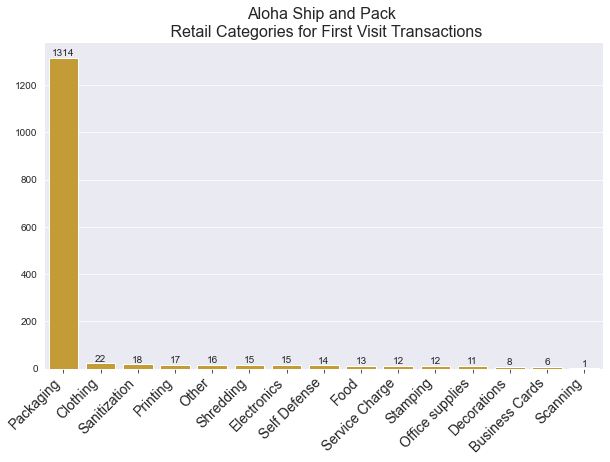

In [314]:
## make results graphable
num_hits, pattern = [], []
for each in first_retail_counts.items():
    num_hits.append(each[1])
    pattern.append(each[0])

pattern = [p.replace("_", ' ') for p in pattern]

###Vizualization
BASE_FONT_SIZE = 14
TITLE_FONT_SIZE = 16
sns.set_style('darkgrid')

#create plot
fig = plt.figure()
fig.set_size_inches(10,6)
g = sns.barplot(x=pattern, y=num_hits, color='goldenrod')

#xaxis
_ = g.xaxis.set_ticklabels(g.xaxis.get_ticklabels(), rotation = 45, ha = 'right', size = BASE_FONT_SIZE)
g.bar_label(g.containers[0])

#other
g.tick_params(bottom=True)
sns.despine(bottom=False, top=True, left=True)

#titles
_ = plt.title("Aloha Ship and Pack \n Retail Categories for First Visit Transactions", fontsize=TITLE_FONT_SIZE)

plt.savefig('figures/retail_cats_1st_purchases_hq.jpg', bbox_inches='tight', dpi=800)
plt.show()

#### T-test on 1st transactions vs overall transactions

In [ ]:
probably would need to comapre the normalized values.  first transactions will by definition be a much smaller size than all transactions

#### All transactions vs 1st transactions normalized as xy scatter plot

In [353]:
i_df = pd.DataFrame(transactions.Department.value_counts(normalize=True))
f_df = pd.DataFrame(first_transactions.original_trans.explode().value_counts(normalize=True))
info_df = pd.merge(i_df, f_df, left_index=True, right_index=True)
info_df.columns = ['All_Trans_Counts', 'First_Trans_Counts']
value = info_df.All_Trans_Counts > info_df.First_Trans_Counts
info_df['color'] = np.where(value, "red", 'plum')

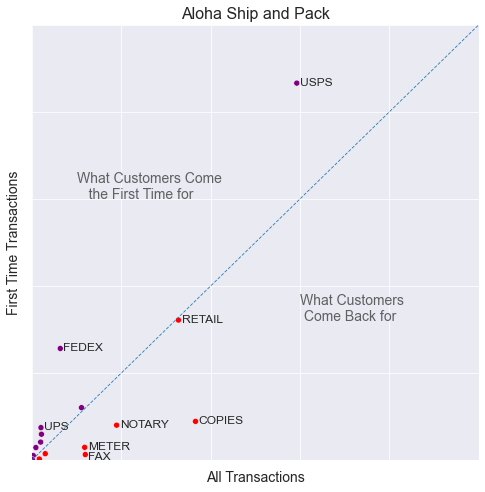

In [357]:
X_OFFSET = 0.0035
Y_OFFSET = -0.003
BASE_FONT_SIZE = 14
TITLE_FONT_SIZE = 16
LABEL_FONT_SIZE = 12
items_to_annotate = ['USPS', 'RETAIL', 'COPIES', 'FEDEX', 'NOTARY', 'FAX', 'UPS', 'METER']
# sns.set_style('darkgrid')

fig = plt.figure()
fig.set_size_inches(8,8)

g = sns.scatterplot(data=info_df, x='All_Trans_Counts', y='First_Trans_Counts', hue='color', palette=['purple','red'])

g.set_xlim((0, 0.5))
g.set_ylim((0, 0.5))
g.axline(xy1=(0,0), slope=1, linewidth=0.8, dashes=(4,2))

g.xaxis.set_ticklabels('')
g.yaxis.set_ticklabels('')

#annotations
for i, (label, xy) in enumerate(info_df.iterrows()):
    # if label in items_to_annotate:

    if label in items_to_annotate:
        if label == 'FAX':
            g.annotate(text=label, xy=(xy[0] + X_OFFSET, xy[1] + Y_OFFSET-0.0025), fontsize=LABEL_FONT_SIZE)
        else:
            g.annotate(text=label, xy=(xy[0] + X_OFFSET, xy[1] + Y_OFFSET), fontsize=LABEL_FONT_SIZE)

g.annotate("What Customers Come \n   the First Time for", xy=(0.05,0.3), fontsize=BASE_FONT_SIZE, alpha=0.7)
g.annotate("What Customers \n Come Back for", xy=(0.3,0.16), fontsize=BASE_FONT_SIZE, alpha=0.7)
#labels and titles
g.yaxis.label.set_text("First Time Transactions")
g.yaxis.label.set_fontsize(BASE_FONT_SIZE)
g.xaxis.label.set_text("All Transactions")
g.xaxis.label.set_fontsize(BASE_FONT_SIZE)
_ = plt.title("Aloha Ship and Pack", fontsize=TITLE_FONT_SIZE)

g.legend("")
g.legend_.remove()

sns.despine(bottom=False, top=True, left=True)

plt.savefig("figures/all-trans_vs_1st-trans.jpg", bbox_inches='tight', dpi=800)
plt.show()

#### How many transactions does each individual customer make

## Where are customers coming from?

In [491]:
address_list = pd.read_csv('data/address_list_trimmed.csv')
address_list.rename(columns={'City/State ' : 'City-State'}, inplace=True)
address_list['Full_Address'] = address_list.Address + ", " + address_list['City-State']

address_list.dropna(inplace=True)
address_list.reset_index(inplace=True, drop=True)

In [492]:
t_map_df = pd.DataFrame(transactions.Customer.unique())
t_map_df.columns = ['Name']

customer_location_df = pd.merge(t_map_df, address_list, how='left', left_on='Name', right_on='Name')
del t_map_df
del address_list
customer_location_df.dropna(inplace=True)
customer_location_df.reset_index(inplace=True, drop=True)

In [530]:
#setup Geolocation encoder
BING_API_K = "AkrYql28S_jhBsb7g_h98xx1BaWVEFexBDp2mlfmjvBjo73vTQPVwnU7rgn6gKT2"
from geopy.geocoders import Bing
gb = Bing(api_key=BING_API_K)
geo_encoder_BING = RateLimiter(gb.geocode, min_delay_seconds=0.75)

#which chunk of customers to run
BEGIN = 1000
END   = 2000
customer_location_df.loc[BEGIN:END, 'location'] = customer_location_df[BEGIN:END].Full_Address.apply(geo_encoder_BING)

RateLimiter caught an error, retrying (0/2 tries). Called with (*('95-1050 Lalai St, Mililani HI, 96789',), **{}).
Traceback (most recent call last):
  File "/opt/miniconda3/envs/py310/lib/python3.10/urllib/request.py", line 1348, in do_open
    h.request(req.get_method(), req.selector, req.data, headers,
  File "/opt/miniconda3/envs/py310/lib/python3.10/http/client.py", line 1276, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/opt/miniconda3/envs/py310/lib/python3.10/http/client.py", line 1322, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/opt/miniconda3/envs/py310/lib/python3.10/http/client.py", line 1271, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/opt/miniconda3/envs/py310/lib/python3.10/http/client.py", line 1031, in _send_output
    self.send(msg)
  File "/opt/miniconda3/envs/py310/lib/python3.10/http/client.py", line 969, in send
    self.connect()
  File "/

In [523]:
sum(customer_location_df.loc[:END, 'location'].isna())
# customer_location_df.head(30)

1

In [529]:
customer_location_df.at[998,'location'].point

Point(21.328582763671875, -158.02293395996094, 0.0)

# Scratchpad area below

In [185]:
df.loc[(df.Event == 'Dance'),'Event']='Hip-Hop'

## dataframe melt thing

In [58]:
df = pd.DataFrame({
    'Factor': ['Growth', 'Value'],
    'Weight': [0.10, 0.20],
    'Variance': [0.15, 0.35]
})

df.head()

,Factor,Weight,Variance
0,Growth,0.1,0.15
1,Value,0.2,0.35


In [59]:
tidy = df.melt(id_vars='Factor').rename(columns=str.title)
tidy.head()

,Factor,Variable,Value
0,Growth,Weight,0.10
1,Value,Weight,0.20
2,Growth,Variance,0.15
3,Value,Variance,0.35


In [191]:
for i, tick_label in enumerate(g.axes.get_xticklabels()):
    print(tick_label.get_text().replace('_', ' '))

Packaging
Clothing
Sanitization
Printing
Other
Shredding
Electronics
Self Defense
Food
Service Charge
Stamping
Office supplies
Decorations
Business Cards
Scanning


In [274]:
for label, xy in info_df.iterrows():
    g.annotate(text=label, xy=(xy[0], xy[1]))
    print(xy)

All_Trans_Counts      0.296349
First_Trans_Counts    0.433095
Name: USPS, dtype: float64
All_Trans_Counts      0.182881
First_Trans_Counts    0.044193
Name: COPIES, dtype: float64
All_Trans_Counts      0.163807
First_Trans_Counts    0.160662
Name: RETAIL, dtype: float64
All_Trans_Counts      0.09452
First_Trans_Counts    0.03983
Name: NOTARY, dtype: float64
All_Trans_Counts      0.059445
First_Trans_Counts    0.006042
Name: FAX, dtype: float64
All_Trans_Counts      0.058778
First_Trans_Counts    0.014321
Name: METER, dtype: float64
All_Trans_Counts      0.055219
First_Trans_Counts    0.059969
Name: Rewards, dtype: float64
All_Trans_Counts      0.031446
First_Trans_Counts    0.127993
Name: FEDEX, dtype: float64
All_Trans_Counts      0.014583
First_Trans_Counts    0.007049
Name: CARDS, dtype: float64
All_Trans_Counts      0.010385
First_Trans_Counts    0.029425
Name: PACK, dtype: float64
All_Trans_Counts      0.009815
First_Trans_Counts    0.037033
Name: UPS, dtype: float64
All_Trans_Cou

In [336]:
info_df

,All_Trans_Counts,First_Trans_Counts,color
USPS,0.296349,0.433095,blue
COPIES,0.182881,0.044193,red
RETAIL,0.163807,0.160662,red
NOTARY,0.094520,0.039830,red
FAX,0.059445,0.006042,red
METER,0.058778,0.014321,red
Rewards,0.055219,0.059969,blue
FEDEX,0.031446,0.127993,blue
CARDS,0.014583,0.007049,red
PACK,0.010385,0.029425,blue


## Geopy

In [502]:
# geolocater = Nominatim(user_agent="asap")
# from geopy.extra.rate_limiter import RateLimiter
# geolocater = RateLimiter(geolocater.geocode, min_delay_seconds=0.5)
